# Searching optimal parallelism configurations

The objective of this notebook is to find the best possible configuration of the downloader. In general we will be interested in optimizing two KPIs:
- the overall download time of a given set of byte ranges
- the time to get the first chunks so that we can get started with processing

We have observed in the `cold_latencies` notebook that download times between consecutive invocations of the same container do not change significantly, so we ignore that dimension in this analysis.

In [1]:
import os

region_name="us-east-2"
binary_name="lambda"
aws_profile=os.environ["AWS_PROFILE"] # Specify the profile you want to use from your .aws/credentials file with the AWS_PROFILE env variable

MEGA = 1024*1024

#### Get the name of the lambda function deployed with the `infra` notebook

In [2]:
lambda_name = !docker run \
    --rm \
    -v $HOME/.aws/credentials:/creds:ro \
    -v cloud-reader-tf:/mnt/state_vol \
    cloudfuse/cloud-reader-terraform output lambda_arn
lambda_name = lambda_name[0][1:len(lambda_name[0])-1]
print('lambda_name:', lambda_name)

lambda_name: arn:aws:lambda:us-east-2:615900053518:function:cloud-reader-benchmark


#### Define the function invokation routines and plotting

We launch multiple invokations in parallel (~100) to get good averages statistics in different locations of the datacenters.

In [3]:
from joblib import Parallel, delayed
import boto3
import json
import base64
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('once')

def q90(x):
    return x.quantile(0.9)
def q99(x):
    return x.quantile(0.99)

# call the AWS Lambda functions with the reader binary
def invoke_function(initial_permits, release_rate, max_parallel, ranges, show_logs = False):
    session = boto3.Session(profile_name=aws_profile)
    client = session.client('lambda', region_name = region_name)
    inputParams = {
        "region": region_name,
        "bucket": "cloudfuse-taxi-data",
        "key": "synthetic/pattern-3gb",
        "size": 1024*1024*16*200,
        "ranges": ranges,
        "max_parallel": max_parallel,
        "initial_permits": initial_permits,
        "release_rate": release_rate,
        
    }
    response = client.invoke(
        FunctionName = lambda_name,
        InvocationType = 'RequestResponse',
        Payload = json.dumps(inputParams),
        LogType='Tail' if show_logs else 'None'
    )
    if show_logs:
        print(base64.b64decode(response['LogResult']).decode("utf-8") )
    return json.load(response['Payload'])

# run `nb_execution` instances in parallel, each trying out all download parallelisms between 1 and `max_max_parallel`
def run_different_parallelism(chunk_megabytes, nb_execution, max_max_parallel):
    def invoke_batch():
        results = []
        for max_parallel in range(1, max_max_parallel+1):
            results.append({
                "response": invoke_function(max_parallel, 1, max_parallel, [{"start": i*chunk_megabytes*MEGA, "length": chunk_megabytes*MEGA} for i in range(0,20)]),
                "max_parallel": max_parallel,
                "initial_permits": max_parallel,
                "release_rate": 1,
            })
        return results

    return  [item for sublist in Parallel(n_jobs=nb_execution)(delayed(invoke_batch)() for i in range(nb_execution)) for item in sublist]

# run `nb_execution` instances in parallel, with a configuration that increases the number of parallel downloads from 1 to 16 gradually
def run_progressive_release(chunk_megabytes, nb_execution):
    def invoke_one():
        return [{
                "response": invoke_function(1, 2, 16, [{"start": i*chunk_megabytes*MEGA, "length": chunk_megabytes*MEGA} for i in range(0,20)]),
                "max_parallel": 16,
                "initial_permits": 1,
                "release_rate": 2,
            }]

    return  [item for sublist in Parallel(n_jobs=nb_execution)(delayed(invoke_one)() for i in range(nb_execution)) for item in sublist]

# flatten the results to a pandas and plot them
def plot_bench(results):
    downloads = []
    for res in results:
        for dl in res['response']['cache_stats']:
            downloads.append({
                "dl_duration": dl['dl_duration'],
                "first_read": res['response']['range_durations'][0],
                "last_read": res['response']['range_durations'][-1],
                "initial_permits": res['initial_permits'],
                "release_rate": res['release_rate'],
                "max_parallel": res['max_parallel'],
            })

    df = pd.DataFrame(downloads)

    df_grouped = df.groupby(['initial_permits', 'release_rate']).agg({
        'dl_duration': 'mean', 
        'first_read': ['mean', q90, q99], 
        'last_read': ['mean', q90, q99]
    }).reset_index(level='release_rate')
    plt.figure();
    
    different_parallelism_df = df_grouped[df_grouped['release_rate']==1].drop(columns=['release_rate'])
    ax = different_parallelism_df.plot(figsize=[20,10], color=['blue', 'lightgreen', 'green', 'darkgreen', 'pink', 'red', 'brown'], grid=True)
    
    progressive_release_df = df_grouped[df_grouped['release_rate']==2].drop(columns=['release_rate'])
    progressive_release_df.plot(figsize=[20,10], color=['blue', 'lightgreen', 'green', 'darkgreen', 'pink', 'red', 'brown'], grid=True, ax=ax, marker='o', legend=False, use_index=False)

### 10MB chunks

**Note:** We ran the same experience at different points in time to check if the results where consistent.

Mon Aug  9 10:33:43 CEST 2021


/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<Figure size 432x288 with 0 Axes>

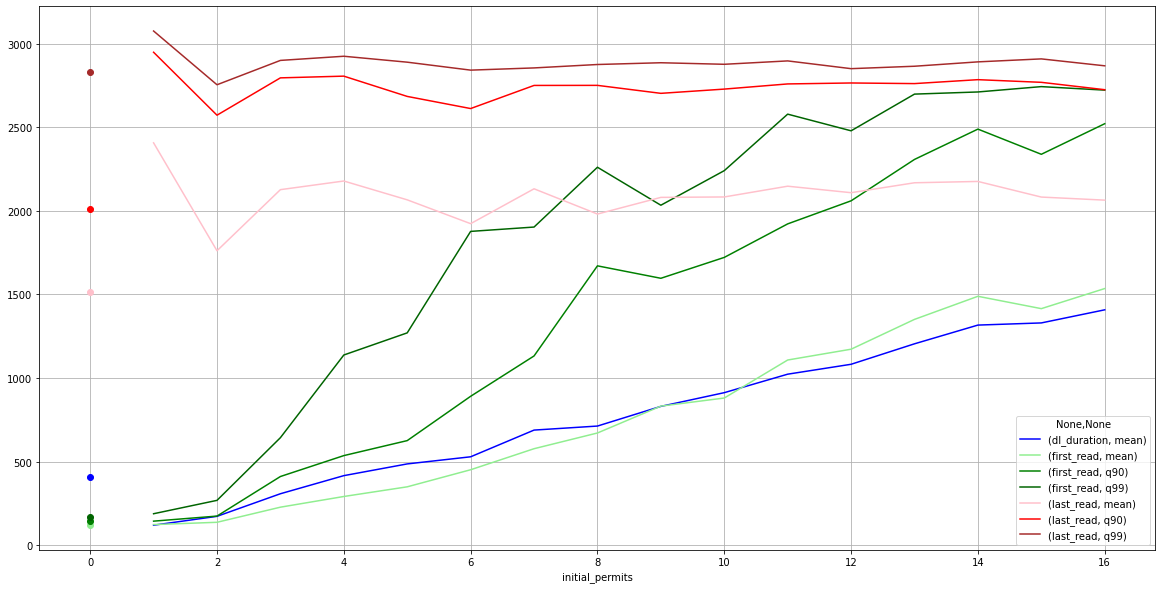

In [42]:
!date
res = run_different_parallelism(chunk_megabytes = 10, nb_execution = 100, max_max_parallel = 16)
res.extend(run_progressive_release(chunk_megabytes = 10, nb_execution = 100))
plot_bench(res)

Mon Aug  9 15:35:16 CEST 2021


/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<Figure size 432x288 with 0 Axes>

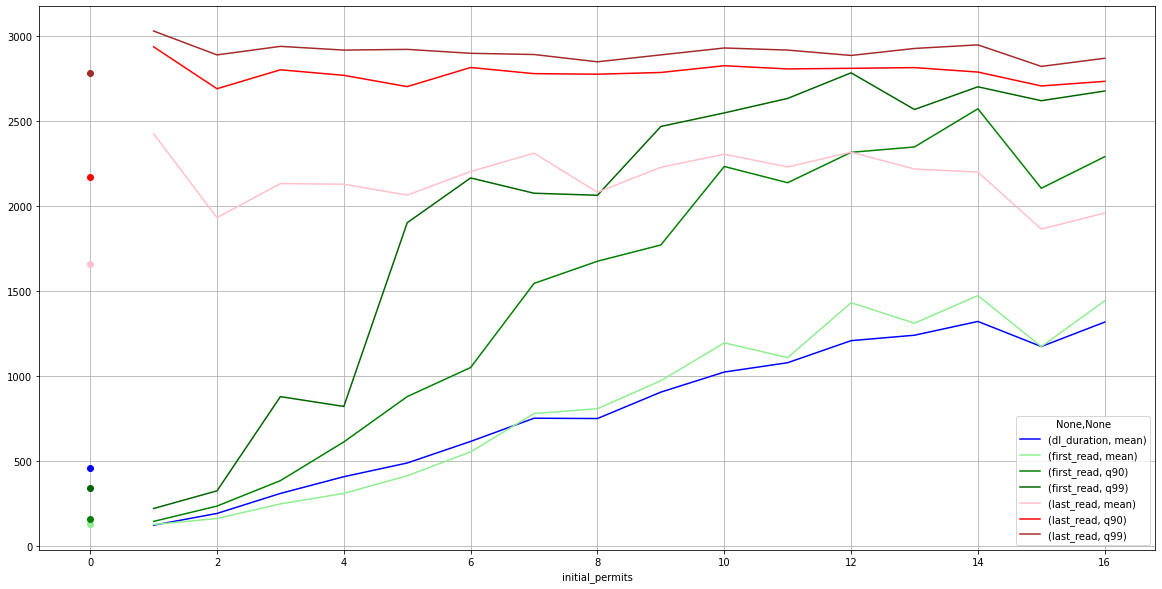

In [4]:
!date
res = run_different_parallelism(chunk_megabytes = 10, nb_execution = 100, max_max_parallel = 16)
res.extend(run_progressive_release(chunk_megabytes = 10, nb_execution = 100))
plot_bench(res)

### 100MB chunks

We also check that the results are similar with larger chunks

Mon Aug  9 10:46:17 CEST 2021


/home/remito/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/remito/.local/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<Figure size 432x288 with 0 Axes>

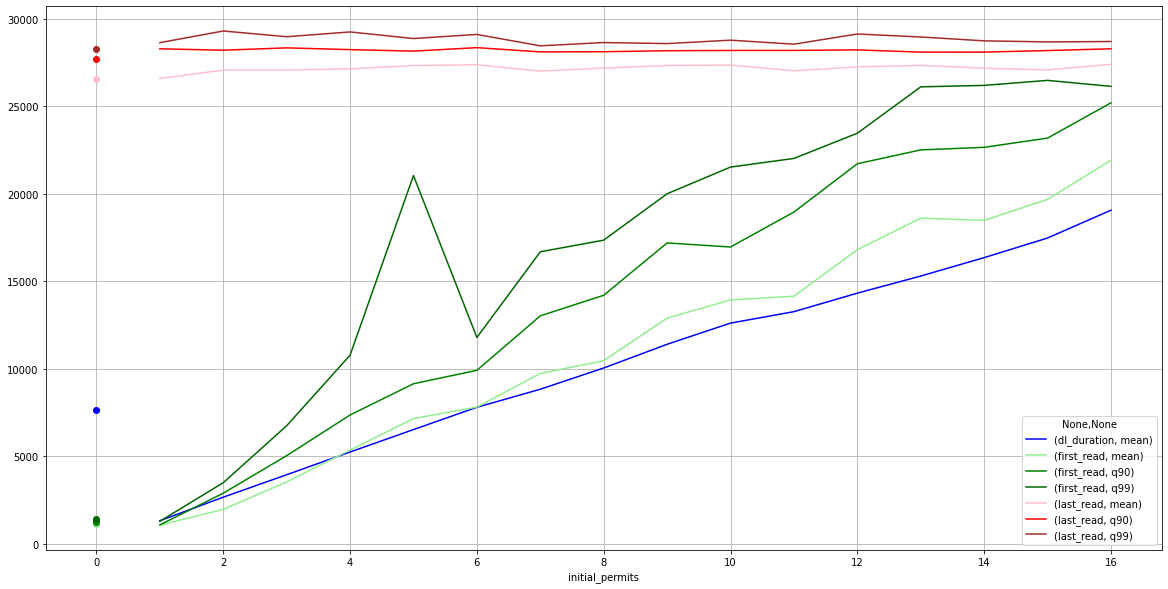

In [47]:
!date
res = run_different_parallelism(chunk_megabytes = 100, nb_execution = 50, max_max_parallel = 16)
res.extend(run_progressive_release(chunk_megabytes = 100, nb_execution = 50))
plot_bench(res)

### Conclusions:

In earlier tests that can be found in the literature such as https://arxiv.org/abs/1911.11727 or the performance guildelines https://docs.aws.amazon.com/AmazonS3/latest/userguide/optimizing-performance-guidelines.html, each individual download request to S3 had a limited bandwidth. This made it very beneficial to have multiple downloads in parallel to increase the total throughput.

These new results tell us a different story. A single connection to S3 mostly fills the maximum available bandwidth between the Lambda and S3 at ~100MB/s. We can see that whatever parallelism we choose, the time to download the whole file (indicated by the `last_read` KPI) remains more or less the same. Having some parallelism slightly helps to fully utilize the bandwidth, but it seems that a parallelism of **2** is enough. 

In this setup, the only KPI that remains to be optimized is the time to first read, to allow us to start the processing of the data as quickly as possible. Having a single download at the beginning then scaling up parallelism progressively helps maintaining a very high bandwidth for the first downloads to get the first chunks quickly, while benefiting from the optimal bandwidth utilization of parallel downloads.

Interestingly, this hybrid approach also provides better total download performances (time to last read), especially with smaller chunks (10MB).